# 財政モデル

蓮見 (2020) の第3章を元にしている。ただし、生産関数は $Y = F(K, AL)$ の形の1次同次関数を想定し、技術水準 $A$ の成長率は $g = const.$, 労働力 $L$ の成長率は $n = const.$ とする。効率労働 $AL$ 1単位あたりの変数について動学方程式を書くと次のようになる。（あってる？）

\begin{align}
k_{t+1} &=
\frac{f\left(k_{t}\right)-c_{t}-g_{t}+\left(1-\delta\right)k_{t}}{\left(1+g\right)\left(1+n\right)}\\
\frac{c_{t+1}}{c_{t}}
&=\frac{1}{1+g}\left[\frac{\left(1+\tau_{c,t}\right)\beta\left\{ \left(1-\tau_{k,t+1}\right)f'\left(k_{t+1}\right)+\left(1-\delta\right)\right\} }{1+\tau_{c,t+1}}\right]^{1/\theta}
\end{align}

それぞれ，[蓮見 (2020)](https://www.nippyo.co.jp/shop/book/8267.html) の式 (3.15), (3.12) に対応する。

記号がややこしいのだけど，添字なしの $g$ は $A$ の成長率，添字付きの $g_t$ は効率労働あたりの政府購入。

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import sympy as sp
sp.init_printing()

import japanize_matplotlib

In [2]:
ka, kt, ca, ct, gt, g, n = sp.symbols("k_{t+1}, k_{t}, c_{t+1}, c_{t}, g_{t}, g, n")
alpha, beta, delta, theta = sp.symbols("alpha beta delta theta")
Tct, Tca, Tka = sp.symbols("\\tau_{c\,t}, \\tau_{c\,t+1}, \\tau_{k\,t+1}")
f = sp.Lambda(kt, kt**alpha)

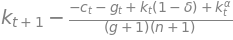

In [3]:
EK = ka - (f(kt) - ct - gt + (1 - delta) * kt) / (1 + g) / (1 + n) 
EK

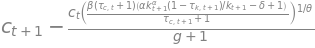

In [4]:
EC = ca - ct * (((1 + Tct) * beta * (
                    (1 - Tka) * f(ka).diff(ka) + 1 - delta
                )) / (1 + Tca)) ** (1 / theta) / (1 + g)
EC

## パラメータ

In [5]:
params = {
    alpha: 0.3,
    delta: 0.25,
    g: 0,
    n: 0,
    theta: 1,
    beta: 0.99
}

In [6]:
def solve_ss(eqm_k, eqm_c, param, x0, tax=[0., 0.], gov=0.1):
    ks, cs = sp.symbols("ks, cs")
    eqm = sp.Matrix([eqm_k.subs({kt: ks, ka: ks, ct: cs, ca: cs,
                                 Tct: tax[1], Tca: tax[1], Tka: tax[0]}),
                     eqm_c.subs({kt: ks, ka: ks, ct: cs, ca: cs,
                                 Tct: tax[1], Tca: tax[1], Tka: tax[0]})])
    
    param.update({ gt: gov })
    eqm_lam = sp.lambdify([[ks, cs]], np.squeeze(eqm.subs(param)))
    J_lam = sp.lambdify([[ks, cs]], eqm.jacobian([ks, cs]).subs(param))
    
    ss = fsolve(func=eqm_lam, x0=x0, fprime=J_lam)
    return ss

In [7]:
ss0 = solve_ss(EK, EC, params, [3, 3])
ss0  #=> (k*, c*)

array([1.22614473, 0.65653543])

## 最適経路の計算

基本はラムゼーモデルと同様。ただし，以下の時系列を入力として与える。すべて同じ長さの NumPy 配列とする。

- `tax_k`: 資本所得税率
- `tax_c`: 消費税率
- `gov`: 政府購入

In [8]:
def solve_optimal_path(eqm_k, eqm_c, k_init, c_final, 
                       param, tax_k, tax_c, gov):
    
    T = len(gov)
    k = sp.symbols(f"k[:{T}]")
    c = sp.symbols(f"c[:{T}]")
    variables = lambda i: {kt: k[i], ka: k[i+1], 
                           ct: c[i], ca: c[i+1],
                           gt: gov[i], Tct: tax_c[i], 
                           Tca: tax_c[i+1], Tka: tax_k[i+1]}
    eqm = sp.Matrix([[eqm_k.subs(variables(i)),
                      eqm_c.subs(variables(i))] for i in range(T-1)])
    eqm_col = eqm.T.reshape(2*T-2, 1)
    
    eqm_param = eqm_col.subs(param).subs({k[0]: k_init, c[-1]: c_final})
    eqm_param = np.squeeze(eqm_param)
    
    eqm_num = sp.lambdify([[*k[1:], *c[:-1]]], eqm_param)
    solution = fsolve(eqm_num, x0=np.ones(2*T-2))
    
    k_sol = np.r_[k_init, solution[:(T-1)]]
    c_sol = np.r_[solution[(T-1):], c_final]
    
    return (k_sol, c_sol)

### 消費増税のシミュレーション

シミュレーション上の仮定：

- 分析の初期には定常状態にある。（→ 資本の初期値）
- シミュレーション期間中の税および政府購入の系列が与えられる。
- シミュレーション期間の終了時における税および政府購入がその後継続するものとする。（→ 消費の終端値）

In [9]:
T = 30
tax_k1 = np.zeros(T)
tax_c1 = np.r_[[0.] * 9, [0.1] * (T-9)]
gov1 = np.ones(T) * 0.1

In [10]:
ss1 = solve_ss(EK, EC, params, [3, 3], 
               tax=[tax_k1[-1], tax_c1[-1]], gov=gov1[-1])
ss1  #=> (k*, c*)

array([1.22614473, 0.65653543])

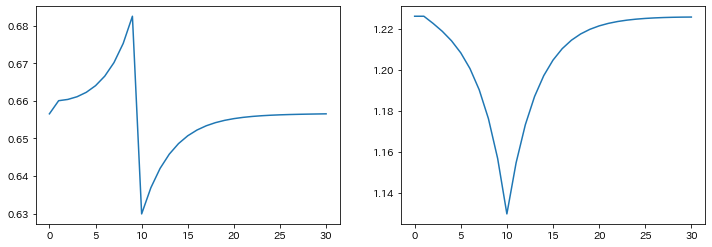

In [11]:
k_sol, c_sol = solve_optimal_path(EK, EC, ss0[0], ss1[1], params,
                                  tax_k1, tax_c1, gov1)
k_sol = np.r_[ss0[0], k_sol]
c_sol = np.r_[ss0[1], c_sol]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(c_sol)
axes[1].plot(k_sol)
plt.show()

### 資本所得税増税のシミュレーション

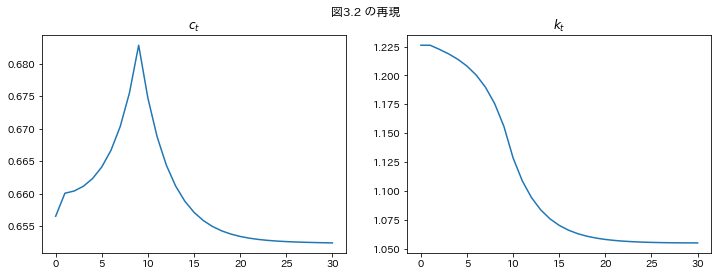

In [12]:
T = 30
tax_k2 = np.r_[[0.] * 9, [0.1] * (T-9)]
tax_c2 = np.zeros(T)
gov2 = np.ones(T) * 0.1

ss2 = solve_ss(EK, EC, params, [3, 3], 
               tax=[tax_k2[-1], tax_c2[-1]], gov=gov2[-1])

k_sol2, c_sol2 = solve_optimal_path(EK, EC, ss0[0], ss2[1], params,
                                    tax_k2, tax_c2, gov2)
k_sol2 = np.r_[ss0[0], k_sol2]
c_sol2 = np.r_[ss0[1], c_sol2]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("図3.2 の再現")
axes[0].plot(c_sol2)
axes[0].set_title("$c_t$")
axes[1].plot(k_sol2)
axes[1].set_title("$k_t$")
plt.show()

## 成長率

せっかく $g$, $n$ をゼロにしなくてよいようにしたので，1つだけチェックしておく。

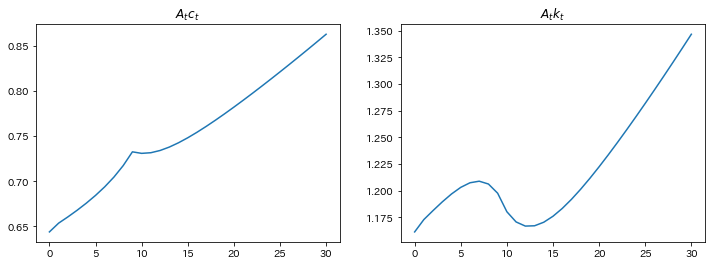

In [13]:
params2 = params.copy()
params2.update({g: 0.01})

ss_g0 = solve_ss(EK, EC, params2, [3, 3])
ss_g1 = solve_ss(EK, EC, params2, [3, 3], 
                 tax=[tax_k2[-1], tax_c2[-1]], gov=gov2[-1])

k_sol3, c_sol3 = solve_optimal_path(EK, EC, ss_g0[0], ss_g1[1], params2,
                                    tax_k2, tax_c2, gov2)
k_sol3 = np.r_[ss_g0[0], k_sol3] * (params2[g] + 1) ** np.arange(T + 1)
c_sol3 = np.r_[ss_g0[1], c_sol3] * (params2[g] + 1) ** np.arange(T + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(c_sol3)
axes[0].set_title("$A_tc_t$")
axes[1].plot(k_sol3)
axes[1].set_title("$A_tk_t$")
plt.show()